#Setup

In [ ]:
import numpy as np
import pandas as pd
import os
import librosa

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import keras.backend as K

# Create Songs DataFrame

In [ ]:
# I load everything from Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# In my "Homework" folder I uploaded the GTZAN folders and files.
os.chdir("/content/drive/My Drive/Colab Notebooks/Homework")

In [ ]:
genres = os.listdir("GTZAN/genres")

In [ ]:
songs = dict()

for genre in genres:
  songs[f'{genre}'] = os.listdir(os.path.join("GTZAN/genres", genre))
  songs[f'{genre}'].sort()

  for i in range(len(songs[f'{genre}'])):
    songs[f'{genre}'][i] = os.path.join("GTZAN/genres", genre, songs[f'{genre}'][i])

In [ ]:
# This way, the DataFrame with song names and labels is created.
df_songs = pd.DataFrame()

for genre in list(songs.keys()):
  df_temp = pd.DataFrame({'file_name': songs[f'{genre}'], 'class_label': f'{genre}'})
  df_songs = pd.concat([df_songs, df_temp], axis = 0)

In [ ]:
df_songs.class_label.value_counts()

hiphop       100
classical    100
blues        100
pop          100
metal        100
reggae       100
disco        100
jazz         100
rock         100
country      100
Name: class_label, dtype: int64

In [ ]:
df_songs.to_csv('Song_Names_and_Labels.csv', index = False)

# Data Preprocessing for DNN

In [ ]:
def extract_features(file_name):
  try:
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 40)
    mfccsscaled = np.mean(mfccs.T,axis=0)
  
  except Exception as e:
    print("Error encountered while parsing file: ", file_name)
    return None
  
  return mfccsscaled

In [ ]:
features = []

for index, row in df_songs.iterrows():
  file_name = row['file_name']
  class_label = row['class_label']
  data = extract_features(file_name)
  features.append([data, class_label])

df_features = pd.DataFrame(features, columns = ['features', 'class_label'])

print(f'The features extraction has been completed ({len(df_features)} files).')

The features extraction has been completed (1000 files)


In [ ]:
df_features.to_csv('Features_and_Labels.csv', index = False)

In [ ]:
df_features.features[0].shape

(40,)

In [ ]:
X = np.array(df_features.features.tolist())
y = np.array(df_features.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 100)

# DNN Model (1st try - Overfitting)

In [ ]:
K.clear_session()

In [ ]:
num_labels = yy.shape[1]

model = Sequential()
model.add(Dense(256, activation = 'relu', input_shape=(40,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_labels, activation = 'softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              metrics = ['accuracy'], 
              optimizer = 'adam')

In [ ]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath = 'DNN_Model_FirstTry', 
                               verbose = 1, 
                               save_best_only = True)

history = model.fit(x_train, y_train, 
                    batch_size = num_batch_size, 
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [checkpointer], 
                    verbose = 1)

Epoch 1/100
 1/20 [>.............................] - ETA: 0s - loss: 17.3731 - accuracy: 0.1875
Epoch 00001: val_loss improved from inf to 3.17706, saving model to DNN_Model_FirstTry
INFO:tensorflow:Assets written to: DNN_Model_FirstTry/assets
20/20 [==============================] - 1s 46ms/step - loss: 9.7873 - accuracy: 0.1969 - val_loss: 3.1771 - val_accuracy: 0.3375
Epoch 2/100
 1/20 [>.............................] - ETA: 0s - loss: 7.9467 - accuracy: 0.2500
Epoch 00002: val_loss improved from 3.17706 to 3.05928, saving model to DNN_Model_FirstTry
INFO:tensorflow:Assets written to: DNN_Model_FirstTry/assets
20/20 [==============================] - 1s 40ms/step - loss: 5.2575 - accuracy: 0.2844 - val_loss: 3.0593 - val_accuracy: 0.3688
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 2.9361 - accuracy: 0.3438
Epoch 00003: val_loss improved from 3.05928 to 1.92843, saving model to DNN_Model_FirstTry
INFO:tensorflow:Assets written to: DNN_Model_FirstTry/assets
20

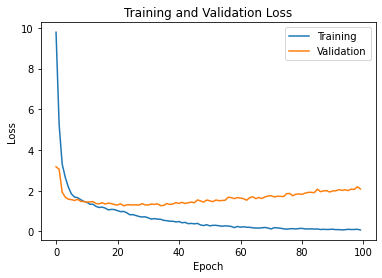

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

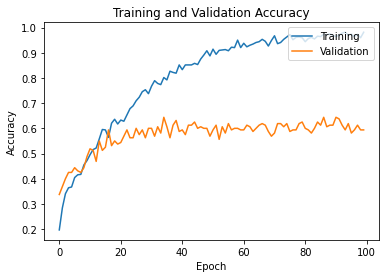

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
training_score = model.evaluate(x_train, y_train, verbose = 0)
print(f'Training Accuracy: {training_score[1]}')

testing_score = model.evaluate(x_test, y_test, verbose = 0)
print(f'Testing Accuracy: {testing_score[1]}')

Training Accuracy: 0.9175000190734863
Testing Accuracy: 0.6499999761581421


#DNN Model (2nd try - Less Overfitting)

## Build the Model

In [ ]:
K.clear_session()

In [ ]:
num_labels = yy.shape[1]

model = Sequential()
model.add(Dense(512, activation = 'relu', input_shape=(40,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              metrics = ['accuracy'], 
              optimizer = 'adam')

In [ ]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath = 'DNN_Model_SecondTry', 
                               verbose = 1, 
                               save_best_only = True)

history = model.fit(x_train, y_train, 
                    batch_size = num_batch_size, 
                    epochs = num_epochs, 
                    validation_data = (x_test, y_test), 
                    callbacks = [checkpointer], 
                    verbose = 1)

Epoch 1/100
24/25 [===========================>..] - ETA: 0s - loss: 13.9724 - accuracy: 0.1302
Epoch 00001: val_loss improved from inf to 2.22831, saving model to DNN_Model_SecondTry
INFO:tensorflow:Assets written to: DNN_Model_SecondTry/assets
25/25 [==============================] - 1s 54ms/step - loss: 13.8159 - accuracy: 0.1300 - val_loss: 2.2283 - val_accuracy: 0.2700
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 5.9483 - accuracy: 0.1937
Epoch 00002: val_loss improved from 2.22831 to 2.02775, saving model to DNN_Model_SecondTry
INFO:tensorflow:Assets written to: DNN_Model_SecondTry/assets
25/25 [==============================] - 1s 60ms/step - loss: 5.9483 - accuracy: 0.1937 - val_loss: 2.0278 - val_accuracy: 0.2900
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 3.7972 - accuracy: 0.1975
Epoch 00003: val_loss improved from 2.02775 to 1.83017, saving model to DNN_Model_SecondTry
INFO:tensorflow:Assets written to: DNN_Model_SecondTry/as

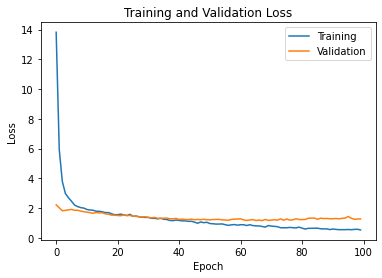

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

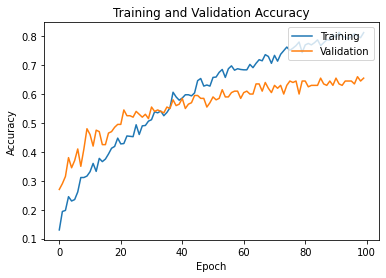

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
training_score = model.evaluate(x_train, y_train, verbose = 0)
print(f'Training Accuracy: {training_score[1]}')

testing_score = model.evaluate(x_test, y_test, verbose = 0)
print(f'Testing Accuracy: {testing_score[1]}')

Training Accuracy: 0.9424999952316284
Testing Accuracy: 0.6549999713897705


## Predictions

In [ ]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name)
    prediction_feature = prediction_feature.reshape(1, 40)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector)
    print("The predicted class is:", predicted_class[0], '\n')

    predicted_proba_vector = model.predict_proba(prediction_feature)
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [ ]:
df_songs.file_name.sample(10)

0                 GTZAN/genres/pop/pop.00000.au
88            GTZAN/genres/disco/disco.00088.au
6           GTZAN/genres/reggae/reggae.00006.au
46            GTZAN/genres/blues/blues.00046.au
34        GTZAN/genres/country/country.00034.au
99            GTZAN/genres/metal/metal.00099.au
62          GTZAN/genres/hiphop/hiphop.00062.au
26    GTZAN/genres/classical/classical.00026.au
83        GTZAN/genres/country/country.00083.au
40            GTZAN/genres/metal/metal.00040.au
Name: file_name, dtype: object

In [ ]:
print_prediction("GTZAN/genres/pop/pop.00000.au")

The predicted class is: pop 

blues 		 :  0.00000000000000000000000002171959
classical 		 :  0.00000000000000000058956889739290
country 		 :  0.00000000000000000000172845306081
disco 		 :  0.00000000000012577512273868884929
hiphop 		 :  0.00000000000041509178906606880588
jazz 		 :  0.00000000000000000000005356333992
metal 		 :  0.00000000000000000000000111994188
pop 		 :  1.00000000000000000000000000000000
reggae 		 :  0.00000000000280745305475393891470
rock 		 :  0.00000000000000000501560923062498


In [ ]:
print_prediction("GTZAN/genres/disco/disco.00088.au")

The predicted class is: disco 

blues 		 :  0.01033904589712619781494140625000
classical 		 :  0.00373272947035729885101318359375
country 		 :  0.01626225560903549194335937500000
disco 		 :  0.40218669176101684570312500000000
hiphop 		 :  0.09506153315305709838867187500000
jazz 		 :  0.00705355918034911155700683593750
metal 		 :  0.17498880624771118164062500000000
pop 		 :  0.00602241838350892066955566406250
reggae 		 :  0.02238322421908378601074218750000
rock 		 :  0.26196974515914916992187500000000


In [ ]:
print_prediction("GTZAN/genres/reggae/reggae.00006.au")

The predicted class is: reggae 

blues 		 :  0.02210941724479198455810546875000
classical 		 :  0.00144793069921433925628662109375
country 		 :  0.04923031106591224670410156250000
disco 		 :  0.01452328450977802276611328125000
hiphop 		 :  0.03037129715085029602050781250000
jazz 		 :  0.00356290466152131557464599609375
metal 		 :  0.00027585448697209358215332031250
pop 		 :  0.00324231246486306190490722656250
reggae 		 :  0.86300945281982421875000000000000
rock 		 :  0.01222728937864303588867187500000


In [ ]:
print_prediction("GTZAN/genres/blues/blues.00046.au")

The predicted class is: blues 

blues 		 :  0.95710760354995727539062500000000
classical 		 :  0.00009624171798350289463996887207
country 		 :  0.01894893683493137359619140625000
disco 		 :  0.00196797051467001438140869140625
hiphop 		 :  0.00090267235646024346351623535156
jazz 		 :  0.00057945476146414875984191894531
metal 		 :  0.00051167019410058856010437011719
pop 		 :  0.00017510019824840128421783447266
reggae 		 :  0.01181065011769533157348632812500
rock 		 :  0.00789972674101591110229492187500


In [ ]:
print_prediction("GTZAN/genres/country/country.00034.au")

The predicted class is: country 

blues 		 :  0.14098773896694183349609375000000
classical 		 :  0.01464466191828250885009765625000
country 		 :  0.59425705671310424804687500000000
disco 		 :  0.02844262868165969848632812500000
hiphop 		 :  0.01263914816081523895263671875000
jazz 		 :  0.04302891343832015991210937500000
metal 		 :  0.00241837045177817344665527343750
pop 		 :  0.02452258579432964324951171875000
reggae 		 :  0.09999917447566986083984375000000
rock 		 :  0.03905973955988883972167968750000


In [ ]:
print_prediction("GTZAN/genres/metal/metal.00099.au")

The predicted class is: metal 

blues 		 :  0.00001597144546394702047109603882
classical 		 :  0.00000131268609493417898193001747
country 		 :  0.00000144903685850295005366206169
disco 		 :  0.00044519378570839762687683105469
hiphop 		 :  0.00818917527794837951660156250000
jazz 		 :  0.00000050951911134688998572528362
metal 		 :  0.99063616991043090820312500000000
pop 		 :  0.00000011965093449362029787153006
reggae 		 :  0.00000369667213817592710256576538
rock 		 :  0.00070649554254487156867980957031


In [ ]:
print_prediction("GTZAN/genres/hiphop/hiphop.00062.au")

The predicted class is: jazz 

blues 		 :  0.06360650062561035156250000000000
classical 		 :  0.02857302315533161163330078125000
country 		 :  0.06868528574705123901367187500000
disco 		 :  0.05731129646301269531250000000000
hiphop 		 :  0.10958036035299301147460937500000
jazz 		 :  0.30688565969467163085937500000000
metal 		 :  0.01029617898166179656982421875000
pop 		 :  0.02333082072436809539794921875000
reggae 		 :  0.25189924240112304687500000000000
rock 		 :  0.07983156293630599975585937500000


In [ ]:
print_prediction("GTZAN/genres/classical/classical.00026.au")

The predicted class is: classical 

blues 		 :  0.00000536777679371880367398262024
classical 		 :  0.99507576227188110351562500000000
country 		 :  0.00000022425712131735053844749928
disco 		 :  0.00000870582607603864744305610657
hiphop 		 :  0.00001243969745701178908348083496
jazz 		 :  0.00488776620477437973022460937500
metal 		 :  0.00000001361417734102587928646244
pop 		 :  0.00000841574728838168084621429443
reggae 		 :  0.00000142611543196835555136203766
rock 		 :  0.00000003646672652735105657484382


In [ ]:
print_prediction("GTZAN/genres/country/country.00083.au")

The predicted class is: country 

blues 		 :  0.00301211304031312465667724609375
classical 		 :  0.00000625219536232179962098598480
country 		 :  0.99277955293655395507812500000000
disco 		 :  0.00017163885058835148811340332031
hiphop 		 :  0.00011899454693775624036788940430
jazz 		 :  0.00017066329019144177436828613281
metal 		 :  0.00005361254443414509296417236328
pop 		 :  0.00000840957454784074798226356506
reggae 		 :  0.00029856828041374683380126953125
rock 		 :  0.00338019500486552715301513671875


In [ ]:
print_prediction("GTZAN/genres/metal/metal.00040.au")

The predicted class is: metal 

blues 		 :  0.00000000124493404474179669705336
classical 		 :  0.00000000001789106363059289606099
country 		 :  0.00000000001636826785222922353569
disco 		 :  0.00000087948762939049629494547844
hiphop 		 :  0.00000034793617942341370508074760
jazz 		 :  0.00000000000256839298093392010003
metal 		 :  0.99995374679565429687500000000000
pop 		 :  0.00000000000060002100944062108923
reggae 		 :  0.00000000013277598465144535566651
rock 		 :  0.00004502281080931425094604492188


Let's try one of the remaining genres (Jazz and Rock) and one more of Hiphop (let's see if the model recognizes it this time).

In [ ]:
print_prediction("GTZAN/genres/jazz/jazz.00069.au")

The predicted class is: jazz 

blues 		 :  0.02027962729334831237792968750000
classical 		 :  0.03805183619260787963867187500000
country 		 :  0.10459154844284057617187500000000
disco 		 :  0.00429753027856349945068359375000
hiphop 		 :  0.00854824017733335494995117187500
jazz 		 :  0.78812819719314575195312500000000
metal 		 :  0.00099609442986547946929931640625
pop 		 :  0.00524471048265695571899414062500
reggae 		 :  0.02009051293134689331054687500000
rock 		 :  0.00977163203060626983642578125000


In [ ]:
print_prediction("GTZAN/genres/rock/rock.00069.au")

The predicted class is: rock 

blues 		 :  0.00366990361362695693969726562500
classical 		 :  0.00009890117507893592119216918945
country 		 :  0.02256220579147338867187500000000
disco 		 :  0.00849812943488359451293945312500
hiphop 		 :  0.00077520706690847873687744140625
jazz 		 :  0.00162345857825130224227905273438
metal 		 :  0.01193407271057367324829101562500
pop 		 :  0.00016093667363747954368591308594
reggae 		 :  0.00362955778837203979492187500000
rock 		 :  0.94704765081405639648437500000000


In [ ]:
print_prediction("GTZAN/genres/hiphop/hiphop.00069.au")

The predicted class is: hiphop 

blues 		 :  0.00000000001672641712635591915159
classical 		 :  0.00000000000018411960595477588898
country 		 :  0.00000000001516268013923571800206
disco 		 :  0.00000008523178962605015840381384
hiphop 		 :  0.99999976158142089843750000000000
jazz 		 :  0.00000000000034299928348968666825
metal 		 :  0.00000008298660958416803623549640
pop 		 :  0.00000000000001078354172314366019
reggae 		 :  0.00000000385478271525130367081147
rock 		 :  0.00000000253358911628254190873122


Nice.

# Data Preprocessing for CNN

In [ ]:
max_pad_len = 1320 # Maximum value of mfccs.shape[1] out of all samples.

In [ ]:
def extract_features_cnn(file_name):
  try:
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
  
  except Exception as e:
    print("Error encountered while parsing file: ", file_name)
    return None
  
  return mfccs

In [ ]:
features_cnn = []

for index, row in df_songs.iterrows():
  file_name = row['file_name']
  class_label = row['class_label']
  data = extract_features_cnn(file_name)
  features_cnn.append([data, class_label])

df_features_cnn = pd.DataFrame(features_cnn, columns = ['features', 'class_label'])

print(f'The features extraction has been completed ({len(df_features_cnn)} files).')

The features extraction has been completed (1000 files).


In [ ]:
df_features_cnn.to_csv('Features_and_Labels_CNN.csv', index = False)

In [ ]:
df_features_cnn.features[0].shape

(40, 1320)

In [ ]:
X = np.array(df_features_cnn.features.tolist())
y = np.array(df_features_cnn.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 100)

# CNN Model

## Build the Model

In [ ]:
K.clear_session()

In [ ]:
num_rows = 40
num_columns = 1320
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2, 
                 input_shape = (num_rows, num_columns, num_channels), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              metrics = ['accuracy'], 
              optimizer = 'adam')

In [ ]:
num_epochs = 50
num_batch_size = 128

checkpointer = ModelCheckpoint(filepath = 'CNN_Model', 
                               verbose = 1, 
                               save_best_only = True)

history = model.fit(x_train, y_train, 
                    batch_size = num_batch_size, 
                    epochs = num_epochs, 
                    validation_data = (x_test, y_test), 
                    callbacks = [checkpointer], 
                    verbose = 1)

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 6.2148 - accuracy: 0.1287
Epoch 00001: val_loss improved from inf to 3.64059, saving model to CNN_Model
INFO:tensorflow:Assets written to: CNN_Model/assets
7/7 [==============================] - 23s 3s/step - loss: 6.2148 - accuracy: 0.1287 - val_loss: 3.6406 - val_accuracy: 0.1300
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 2.7225 - accuracy: 0.1787
Epoch 00002: val_loss improved from 3.64059 to 2.31236, saving model to CNN_Model
INFO:tensorflow:Assets written to: CNN_Model/assets
7/7 [==============================] - 23s 3s/step - loss: 2.7225 - accuracy: 0.1787 - val_loss: 2.3124 - val_accuracy: 0.1350
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 1.9791 - accuracy: 0.2612
Epoch 00003: val_loss improved from 2.31236 to 1.93456, saving model to CNN_Model
INFO:tensorflow:Assets written to: CNN_Model/assets
7/7 [==============================] - 23s 3s/step - loss: 1.9791 - accu

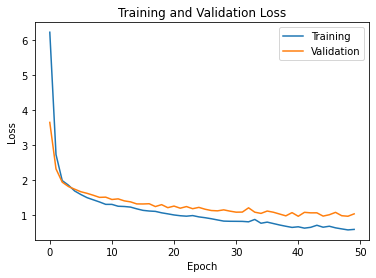

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

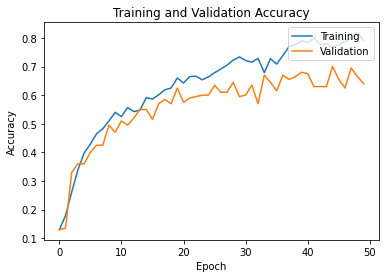

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
training_score = model.evaluate(x_train, y_train, verbose = 0)
print(f'Training Accuracy: {training_score[1]}')

testing_score = model.evaluate(x_test, y_test, verbose = 0)
print(f'Testing Accuracy: {testing_score[1]}')

Training Accuracy: 0.7975000143051147
Testing Accuracy: 0.6399999856948853


## Predictions

In [ ]:
def print_prediction_cnn(file_name):
    prediction_feature = extract_features_cnn(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [ ]:
print_prediction_cnn("GTZAN/genres/pop/pop.00000.au")

The predicted class is: pop 

blues 		 :  0.00004050680581713095307350158691
classical 		 :  0.00000780637583375209942460060120
country 		 :  0.00046915889834053814411163330078
disco 		 :  0.01671979576349258422851562500000
hiphop 		 :  0.00433903513476252555847167968750
jazz 		 :  0.00416142214089632034301757812500
metal 		 :  0.00000234352364714141003787517548
pop 		 :  0.95746529102325439453125000000000
reggae 		 :  0.00449216086417436599731445312500
rock 		 :  0.01230249460786581039428710937500


In [ ]:
print_prediction_cnn("GTZAN/genres/disco/disco.00088.au")

The predicted class is: rock 

blues 		 :  0.00331091741099953651428222656250
classical 		 :  0.00080385460751131176948547363281
country 		 :  0.01140067633241415023803710937500
disco 		 :  0.09027677774429321289062500000000
hiphop 		 :  0.00514201354235410690307617187500
jazz 		 :  0.00489959958940744400024414062500
metal 		 :  0.20859144628047943115234375000000
pop 		 :  0.00000072122332994695170782506466
reggae 		 :  0.00187060493044555187225341796875
rock 		 :  0.67370337247848510742187500000000


In [ ]:
print_prediction_cnn("GTZAN/genres/reggae/reggae.00006.au")

The predicted class is: reggae 

blues 		 :  0.06782383471727371215820312500000
classical 		 :  0.00143079971894621849060058593750
country 		 :  0.33166673779487609863281250000000
disco 		 :  0.00410197721794247627258300781250
hiphop 		 :  0.00316367996856570243835449218750
jazz 		 :  0.00049689435400068759918212890625
metal 		 :  0.00000907417506823549047112464905
pop 		 :  0.00097854656632989645004272460938
reggae 		 :  0.38236001133918762207031250000000
rock 		 :  0.20796841382980346679687500000000


In [ ]:
print_prediction_cnn("GTZAN/genres/blues/blues.00046.au")

The predicted class is: blues 

blues 		 :  0.77343738079071044921875000000000
classical 		 :  0.00000145332808187959017232060432
country 		 :  0.05935002490878105163574218750000
disco 		 :  0.00297893048264086246490478515625
hiphop 		 :  0.00666435388848185539245605468750
jazz 		 :  0.00031695506186224520206451416016
metal 		 :  0.00709190173074603080749511718750
pop 		 :  0.00004375212665763683617115020752
reggae 		 :  0.04858624935150146484375000000000
rock 		 :  0.10152900218963623046875000000000


In [ ]:
print_prediction_cnn("GTZAN/genres/country/country.00034.au")

The predicted class is: reggae 

blues 		 :  0.01267684251070022583007812500000
classical 		 :  0.02207364886999130249023437500000
country 		 :  0.23439498245716094970703125000000
disco 		 :  0.12466505169868469238281250000000
hiphop 		 :  0.00601097429171204566955566406250
jazz 		 :  0.01247928850352764129638671875000
metal 		 :  0.00000657491227684658952057361603
pop 		 :  0.04070705547928810119628906250000
reggae 		 :  0.38520494103431701660156250000000
rock 		 :  0.16178067028522491455078125000000


In [ ]:
print_prediction_cnn("GTZAN/genres/metal/metal.00099.au")

The predicted class is: metal 

blues 		 :  0.01008549332618713378906250000000
classical 		 :  0.00010854120773728936910629272461
country 		 :  0.00352971325628459453582763671875
disco 		 :  0.05166629329323768615722656250000
hiphop 		 :  0.10727365314960479736328125000000
jazz 		 :  0.00004257890395820140838623046875
metal 		 :  0.76152938604354858398437500000000
pop 		 :  0.00000093825178737461101263761520
reggae 		 :  0.00239461800083518028259277343750
rock 		 :  0.06336878240108489990234375000000


In [ ]:
print_prediction_cnn("GTZAN/genres/hiphop/hiphop.00062.au")

The predicted class is: hiphop 

blues 		 :  0.00000275421825790544971823692322
classical 		 :  0.00000040961467107081261929124594
country 		 :  0.00004369487578514963388442993164
disco 		 :  0.02330480143427848815917968750000
hiphop 		 :  0.77056682109832763671875000000000
jazz 		 :  0.00000083204969314465415664017200
metal 		 :  0.00000067380670998318237252533436
pop 		 :  0.00050328910583630204200744628906
reggae 		 :  0.20426410436630249023437500000000
rock 		 :  0.00131262512877583503723144531250


In [ ]:
print_prediction_cnn("GTZAN/genres/classical/classical.00026.au")

The predicted class is: classical 

blues 		 :  0.00000005728255203507615078706294
classical 		 :  0.99922621250152587890625000000000
country 		 :  0.00000125684482554788701236248016
disco 		 :  0.00000001278402539384160263580270
hiphop 		 :  0.00000000120325627239736832052586
jazz 		 :  0.00065039616310968995094299316406
metal 		 :  0.00000000001124354429005158806376
pop 		 :  0.00011466983414720743894577026367
reggae 		 :  0.00000003376252522002687328495085
rock 		 :  0.00000729665089238551445305347443


In [ ]:
print_prediction_cnn("GTZAN/genres/country/country.00083.au")

The predicted class is: country 

blues 		 :  0.00045465840958058834075927734375
classical 		 :  0.00009779064566828310489654541016
country 		 :  0.99171429872512817382812500000000
disco 		 :  0.00029328759410418570041656494141
hiphop 		 :  0.00002472329651936888694763183594
jazz 		 :  0.00002114016206178348511457443237
metal 		 :  0.00000731167119738529436290264130
pop 		 :  0.00000103496347492182394489645958
reggae 		 :  0.00018836576782632619142532348633
rock 		 :  0.00719734327867627143859863281250


In [ ]:
print_prediction_cnn("GTZAN/genres/metal/metal.00040.au")

The predicted class is: metal 

blues 		 :  0.00002068891080853063613176345825
classical 		 :  0.00000005756362142506077361758798
country 		 :  0.00016232431516982614994049072266
disco 		 :  0.00183213991113007068634033203125
hiphop 		 :  0.00003832299626083113253116607666
jazz 		 :  0.00000047770708988537080585956573
metal 		 :  0.98828250169754028320312500000000
pop 		 :  0.00000000015826825960907342505379
reggae 		 :  0.00000478589663543971255421638489
rock 		 :  0.00965868216007947921752929687500


In [ ]:
print_prediction_cnn("GTZAN/genres/jazz/jazz.00069.au")

The predicted class is: jazz 

blues 		 :  0.00924892257899045944213867187500
classical 		 :  0.00900574959814548492431640625000
country 		 :  0.19297853112220764160156250000000
disco 		 :  0.00304621807299554347991943359375
hiphop 		 :  0.00012932358367834240198135375977
jazz 		 :  0.71938657760620117187500000000000
metal 		 :  0.00000871703377924859523773193359
pop 		 :  0.01771638542413711547851562500000
reggae 		 :  0.00349148036912083625793457031250
rock 		 :  0.04498801380395889282226562500000


In [ ]:
print_prediction_cnn("GTZAN/genres/rock/rock.00069.au")

The predicted class is: rock 

blues 		 :  0.00078763469355180859565734863281
classical 		 :  0.00001089360921469051390886306763
country 		 :  0.24096852540969848632812500000000
disco 		 :  0.00506806513294577598571777343750
hiphop 		 :  0.00072708335937932133674621582031
jazz 		 :  0.00162243354134261608123779296875
metal 		 :  0.00037651511956937611103057861328
pop 		 :  0.00000077665680464633624069392681
reggae 		 :  0.00187070982065051794052124023438
rock 		 :  0.74856734275817871093750000000000


In [ ]:
print_prediction_cnn("GTZAN/genres/disco/disco.00096.au")

The predicted class is: disco 

blues 		 :  0.02098001725971698760986328125000
classical 		 :  0.00612952979281544685363769531250
country 		 :  0.00141155219171196222305297851562
disco 		 :  0.50970590114593505859375000000000
hiphop 		 :  0.25401207804679870605468750000000
jazz 		 :  0.01114282757043838500976562500000
metal 		 :  0.00471942685544490814208984375000
pop 		 :  0.00003741619730135425925254821777
reggae 		 :  0.03643073514103889465332031250000
rock 		 :  0.15543061494827270507812500000000
